In [171]:
import keras
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [172]:
# yahoo finance からLasertecの2018年1月1日以来の時列データセットを抽出し、データの形式を確認
df1 = yf.download("6919.T",start='2018-01-01',end = datetime.now(),interval="1d")
df1.head()
df2 = yf.download("6920.T", start='2018-01-01', end=datetime.now(), interval="1d")
df3 = yf.download("6918.T", start='2018-01-01', end=datetime.now(), interval="1d")


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


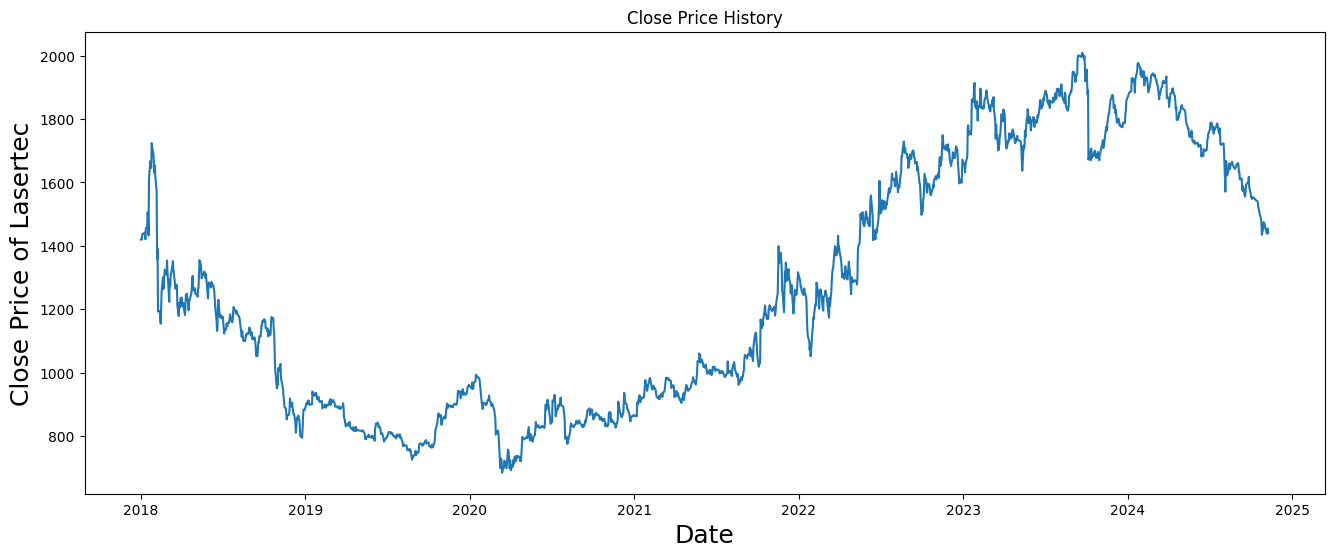

In [173]:
# datasetをplotして可視化
plt.figure(figsize=(16,6))
plt.title('Close Price History')
plt.plot(df1['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price of Lasertec', fontsize=18)
plt.show()

In [ ]:
# 必要な特徴量を抽出
features = ['Close']
data1 = df1[features]
data2 = df2[features]
data3 = df3[features]

# 各データフレームの欠損値を前方補完と後方補完で補完
data1 = data1.fillna(method='ffill').fillna(method='bfill')
data2 = data2.fillna(method='ffill').fillna(method='bfill')
data3 = data3.fillna(method='ffill').fillna(method='bfill')

# データの形状を確認
print("Data1 shape:", data1.shape)
print("Data2 shape:", data2.shape)
print("Data3 shape:", data3.shape)

# データの結合
combined_data = pd.concat([data1, data2, data3], axis=1)

# 結合後のデータの形状を確認
print("Combined data shape:", combined_data.shape)

# 欠損値の確認
print("Missing values before dropna:", combined_data.isnull().sum())

# 欠損値の削除
combined_data = combined_data.dropna()

# 欠損値削除後のデータの形状を確認
print("Combined data shape after dropna:", combined_data.shape)

# データの正規化
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(combined_data)

# 正規化後のデータの形状を確認
print("Scaled data shape:", scaled_data.shape)

Data1 shape: (1688, 1)
Data2 shape: (1688, 1)
Data3 shape: (1688, 1)
Combined data shape: (1688, 3)
Missing values before dropna: Price  Ticker
Close  6919.T    0
       6920.T    0
       6918.T    0
dtype: int64
Combined data shape after dropna: (1688, 3)
Scaled data shape: (1688, 3)


In [175]:
# データを訓練データと検証データに分割
training_data_len = int(np.ceil(len(scaled_data) * 0.7))
train_data = scaled_data[0:training_data_len]
test_data = scaled_data[training_data_len:]

In [176]:
train_data = np.reshape(train_data, (train_data.shape[0], 1, train_data.shape[1]))
test_data = np.reshape(test_data, (test_data.shape[0], 1, test_data.shape[1]))

In [177]:
# #訓練データの取得
# x_train = []
# y_train = []
# for i in range(60, len(train_data)): 
#     x_train.append(train_data[i-60:i,0])
#     y_train.append(train_data[i,0])

# # 訓練データのreshape
# x_train, y_train = np.array(x_train), np.array(y_train)
# x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
# x_train.shape

In [178]:
#LSTMモデル構築
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(train_data.shape[1], train_data.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# モデルのコンパイル
model.compile(optimizer='adam', loss='mean_squared_error')

# モデルの訓練
model.fit(train_data, epochs=1, batch_size=1)

ValueError: None values not supported.

In [ ]:
test_df = yf.download("6917.T",start='2018-01-01',end = datetime.now(),interval="1d")

test_data = test_df['Close'].values.reshape(-1, 1)
scaled_test_data = scaler.transform(test_data)

[*********************100%***********************]  1 of 1 completed


ValueError: X has 5 features, but MinMaxScaler is expecting 3 features as input.

In [ ]:
# 検証用データを取得とデータ変換
test_data = scaled_test_data[training_data_len - 60: , :]
x_test = []
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
y_test = test_data[60:, 0]

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

# 予測値の算出
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# RMSEを利用して予測精度を確認
test_score = np.sqrt(mean_squared_error(y_test,predictions))
print('Test Score: %.2f RMSE' % (test_score))

IndexError: tuple index out of range

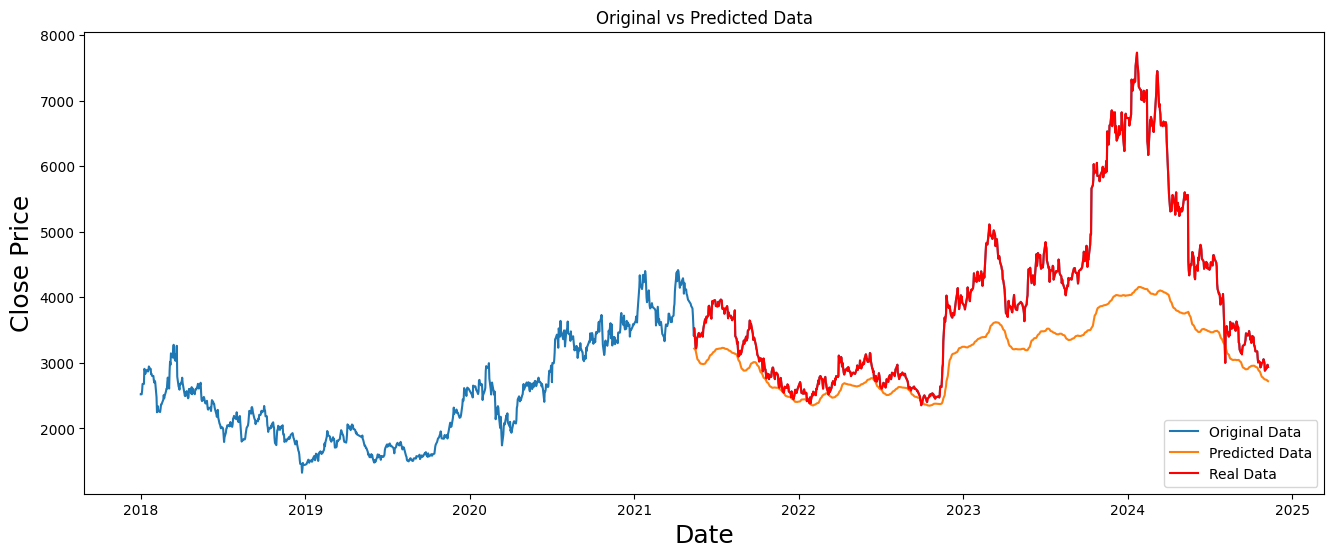

In [ ]:
# 訓練データと検証データの設定
train = test_df[:training_data_len]
valid = test_df[training_data_len:training_data_len + len(predictions)]
valid['Predictions'] = predictions

# プロット
plt.figure(figsize=(16,6))
plt.title('Original vs Predicted Data')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price', fontsize=18)
plt.plot(test_df.index, test_df['Close'], label='Original Data')
plt.plot(valid.index, valid['Predictions'], label='Predicted Data')
plt.plot(valid.index, valid['Close'], label='Real Data', color='red')
plt.legend(['Original Data', 'Predicted Data', 'Real Data'], loc='lower right')
plt.show()

In [202]:
import keras
import pandas as pd
from datetime import datetime
import numpy as np
from matplotlib import style
import matplotlib.pyplot as plt
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

# yahoo finance からLasertecの2018年1月1日以来の時列データセットを抽出し、データの形式を確認
df = yf.download("6920.T",start='2018-01-01',end = datetime.now(),interval="1d")

#　Closeコラムのみ抽出
data = df["Close"]
dataset = data.values
#　データの正規化
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

# データを訓練データと検証データに分割し、7割が訓練用に設定
training_data_len = int(np.ceil(len(dataset) * 0.7))
training_data_len

train_data = scaled_data[0: int(training_data_len), :]
train_data.shape

#訓練データの取得
x_train = []
y_train = []
for i in range(60, len(train_data)): 
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])

# 訓練データのreshape
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], 1))
x_train.shape

# kerasから必要なライブラリを導入
from keras.models import Sequential
from keras.layers import Dense, LSTM

#LSTMモデル構築
model = Sequential()
model.add(LSTM(128,return_sequences = True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences = False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mean_squared_error')

#訓練用モデル構築
model.fit(x_train, y_train, batch_size = 1, epochs =1)

# 検証用データを取得とデータ変換
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
for i in range(60, len(test_data)):
   x_test.append(test_data[i-60:i,0])
y_test = dataset[training_data_len:, :]

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))

# 予測値の算出
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# RMSEを利用して予測精度を確認
from sklearn.metrics import mean_squared_error
test_score = np.sqrt(mean_squared_error(y_test,predictions))
print('Test Score: %.2f RMSE' % (test_score))

[*********************100%***********************]  1 of 1 completed


1122/1122 ━━━━━━━━━━━━━━━━━━━━ 29s 24ms/step - loss: 0.0030
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Test Score: 2108.24 RMSE


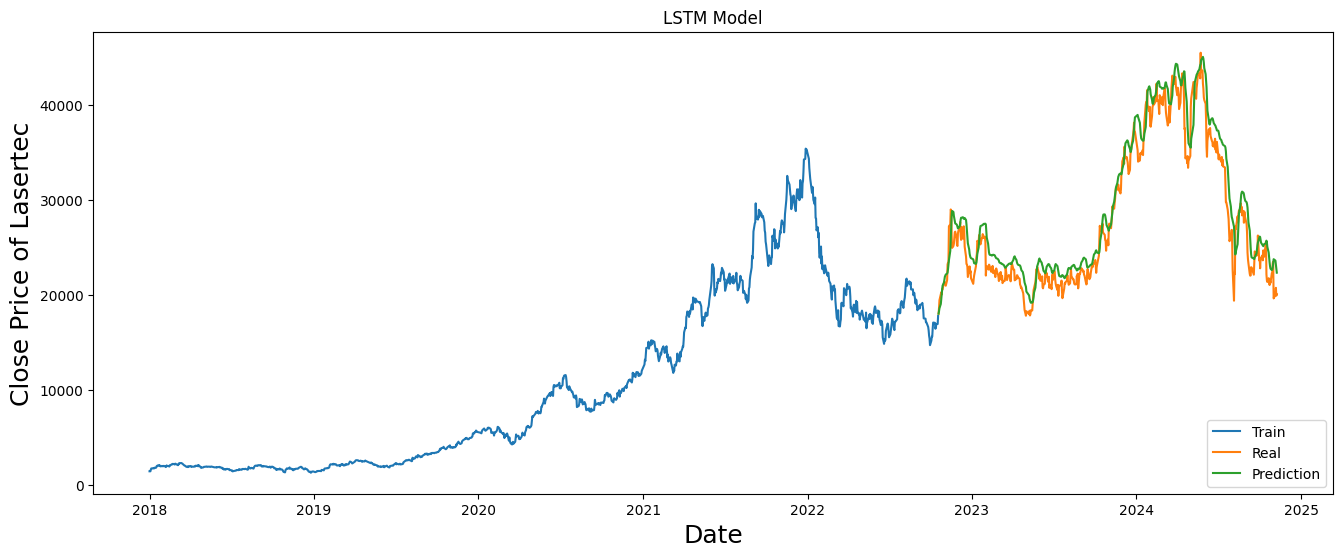

In [203]:
train = df[: training_data_len]
valid = df[training_data_len:]
valid['Predictions'] = predictions

plt.figure(figsize = (16,6))
plt.title('LSTM Model')
plt.xlabel('Date', fontsize =18)
plt.ylabel('Close Price of Lasertec', fontsize =18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Train','Real','Prediction'], loc='lower right')
plt.show()